<table align="center">
  <td align="center"><a target="_blank" href="#/">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="#/">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np
import string

from tensorflow.keras import layers
from tensorflow.keras import losses

First, the binary dataset that already being preprocessed is imported, with the labels are 1 for hateful comment and 0 for regular comment.

In [ ]:
url = 'drive/MyDrive/dataset/binary_comment_dataset.csv'

dataset = pd.read_csv(url, encoding = 'utf8')

dataset.head()

,comment_text,hateful
0,was taken from britannica and columbia encyclo...,0
1,i think i got blocked for a bad reason as show...,1
2,go ahead make my day go ahead and block me ada...,1
3,request for arbitrationcoolkatt based on your ...,0
4,you are nothing more than a malignant cancer o...,1


Next, the data is splitted in to 3 part:

*   Training dataset: feed into model for training the behaviour (70% of whole data)
*   Validation dataset: use to validate the model whether it is fit, overfit or underfit (20%)
*   Testing dataset: use for test and evaluation of the model (10%)




In [ ]:
raw_train, raw_validation, raw_test = np.split(dataset.sample(frac=1), [int(0.7*len(dataset)), int(0.9*len(dataset))])

print(len(raw_train), 'training examples')
print(len(raw_validation), 'validation examples')
print(len(raw_test), 'test examples')

def df_to_dataset(dataframe, shuffle=True, batch_size=2048):
  df = dataframe.copy()
  labels = df.pop('hateful')
  df = df['comment_text'].astype(str)
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

raw_train_ds = df_to_dataset(raw_train)
raw_val_ds = df_to_dataset(raw_validation)
raw_test_ds = df_to_dataset(raw_test)

200652 training examples
57329 validation examples
28665 test examples


# Text Vectorization

max_features -> vocabulary size -> 220 000

seq_len

In [ ]:
max_features = 220000
sequence_length = 250

def custom_standardization(input):
  lowercase = tf.strings.lower(input)
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_sequence_length=sequence_length,
    output_mode='int'
)

train_text = raw_train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# CNN

In [ ]:
# nums of character in a word
embedding_dim = 26

model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 26)          5720000   
                                                                 
 dropout_6 (Dropout)         (None, None, 26)          0         
                                                                 
 global_average_pooling1d_3  (None, 26)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_7 (Dropout)         (None, 26)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                432       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                      

# Training

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
98/98 [==============================] - 43s 430ms/step - loss: 0.6811 - binary_accuracy: 0.5783 - val_loss: 0.6549 - val_binary_accuracy: 0.6479
Epoch 2/10
98/98 [==============================] - 38s 384ms/step - loss: 0.6020 - binary_accuracy: 0.7097 - val_loss: 0.5362 - val_binary_accuracy: 0.7869
Epoch 3/10
98/98 [==============================] - 40s 404ms/step - loss: 0.4806 - binary_accuracy: 0.8179 - val_loss: 0.4307 - val_binary_accuracy: 0.8521
Epoch 4/10
98/98 [==============================] - 38s 383ms/step - loss: 0.3977 - binary_accuracy: 0.8618 - val_loss: 0.3692 - val_binary_accuracy: 0.8758
Epoch 5/10
98/98 [==============================] - 37s 383ms/step - loss: 0.3435 - binary_accuracy: 0.8859 - val_loss: 0.3255 - val_binary_accuracy: 0.8928
Epoch 6/10
98/98 [==============================] - 41s 416ms/step - loss: 0.3010 - binary_accuracy: 0.9036 - val_loss: 0.2896 - val_binary_accuracy: 0.9069
Epoch 7/10
98/98 [==============================] - 40s 40

# Evaluation

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

14/14 [==============================] - 1s 69ms/step - loss: 0.1932 - binary_accuracy: 0.9441
Loss:  0.1932007074356079
Accuracy:  0.9440781474113464


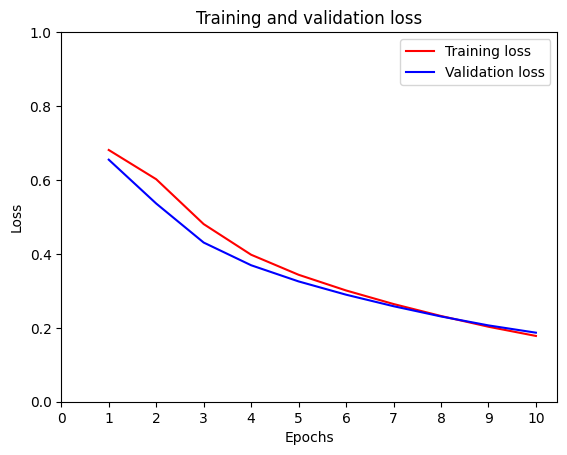

In [ ]:
history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xticks(np.arange(0, len(acc) + 1, 1))
plt.legend()

plt.show()

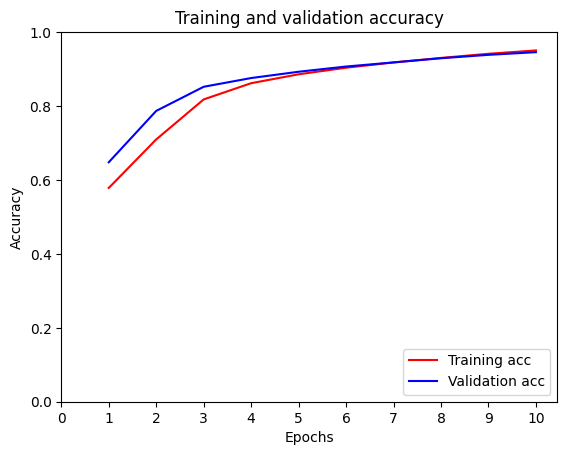

In [ ]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xticks(np.arange(0, len(acc) + 1, 1))
plt.legend(loc='lower right')

plt.show()

# Exporting the model

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model
])

export_model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

1/1 [==============================] - 0s 26ms/step
Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,


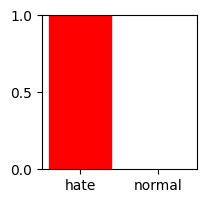

Dear god this site is horrible.


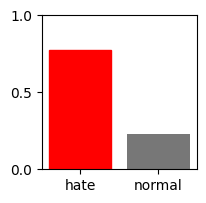

Only a fool can believe in such numbers.


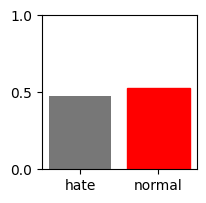

I have indefinitely blocked this account.


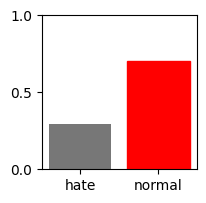

Please stop. If you continue to vandalize TikTok, as you did to Homosexuality, you will be blocked from editing.


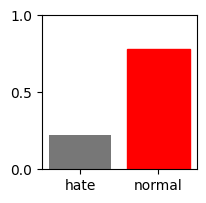

I've deleted the page , as we have no evidence that you are the person named on that page, and its content goes against Wikipedia's policies for the use of user pages.


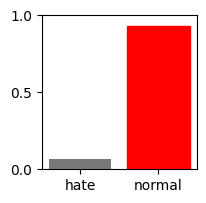

The word bitch is from the Old Norse Bikkjuna meaning female of the dog of unknown origin, Grimm derives the Old Norse words from Lapp Pittja, But OED notes that the converse is equally possible. 


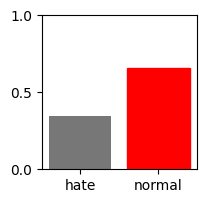

The adj. Bitchy was first seen in 1925.


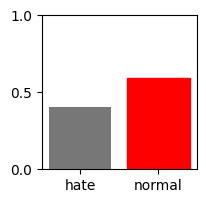

The word bitch is actually only offencive in American and Canadian English. In most other English variants bitch maintains it's correct definition - female canine. People have argued that bitch is different because it is used as an insult - but so is pig, dog, cow and others. These are not considered profane, so why is bitch? As far as I am concerned, there is nothing to reclaim as bitch simply means a female canine.


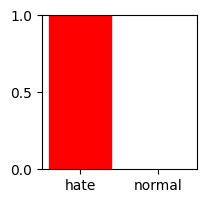

Hi... Bitch


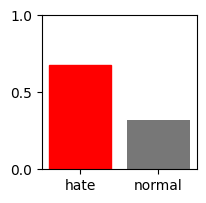

HIS DICK IS MIGHTY FINE!!!!!!!!!!


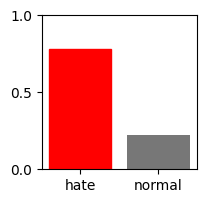

Discard All said previously... We love you Carlos... I LOVE YOU! I WANT TO RAPE YOU O Just Kidding


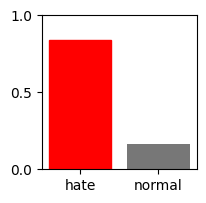

dffhdfdfghldfugdfhdiufhudifhgudighdfu fuck yo bfhiffbifbdufh wilvingstone simplice


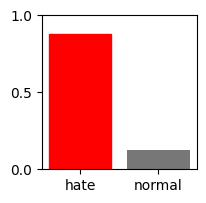

In [ ]:
inputs = [
  "Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,",
  "Dear god this site is horrible.",
  "Only a fool can believe in such numbers.",
  "I have indefinitely blocked this account.",
  "Please stop. If you continue to vandalize TikTok, as you did to Homosexuality, you will be blocked from editing.",
  "I've deleted the page , as we have no evidence that you are the person named on that page, and its content goes against Wikipedia's policies for the use of user pages.",
  "The word bitch is from the Old Norse Bikkjuna meaning female of the dog of unknown origin, Grimm derives the Old Norse words from Lapp Pittja, But OED notes that the converse is equally possible. ",
  "The adj. Bitchy was first seen in 1925.",
  "The word bitch is actually only offencive in American and Canadian English. In most other English variants bitch maintains it's correct definition - female canine. People have argued that bitch is different because it is used as an insult - but so is pig, dog, cow and others. These are not considered profane, so why is bitch? As far as I am concerned, there is nothing to reclaim as bitch simply means a female canine.",
  "Hi... Bitch",
  "HIS DICK IS MIGHTY FINE!!!!!!!!!!",
  "Discard All said previously... We love you Carlos... I LOVE YOU! I WANT TO RAPE YOU O Just Kidding",
  "dffhdfdfghldfugdfhdiufhudifhgudighdfu fuck yo bfhiffbifbdufh wilvingstone simplice",
]

examples = tf.constant(inputs)

predictions = export_model.predict(examples)

def plot_value_array(percent):
  thisplot = plt.bar(range(2), [percent, 1.0 - percent], color="#777777")
  plt.xticks(range(2), ['hate', 'normal'])
  plt.yticks([0, 0.5, 1])
  plt.ylim([0, 1])
  predicted_label = 0 if percent >= 0.5 else 1
  thisplot[predicted_label].set_color('red')

for i in range(len(inputs)):
  plt.figure(figsize=(2, 2))
  print(inputs[i])
  plot_value_array(predictions[i][0])
  plt.show()